In [4]:
import pandas as pd
import numpy as np

import re

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tabulate import tabulate

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt_tab')
nltk.download('stopwords')

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from gensim.models import Word2Vec



[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/cybercampus/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/cybercampus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
csv_files = pd.read_csv('shopee_scincare_reviews_final.csv')

scincare_reviews_df = pd.DataFrame(csv_files)
scincare_reviews_df = scincare_reviews_df.drop(columns=["product_name"])

clean_df = scincare_reviews_df.dropna()
clean_df = clean_df.drop_duplicates()
clean_df.shape

print(f"Initial shape: {clean_df.shape}")
scincare_reviews_df.head()


Initial shape: (26882, 2)


,rating,comment
0,5,"Pengiriman cepat, dan baru pertama kali nyobai..."
1,5,Pengiriman relatif cepatpacking super aman nia...
2,5,"Pertama kali coba dan beli pas lagi live, luma..."
3,5,Makasih ya paketnya sudah sampai dengan baik p...
4,5,Wangi:tidak ada wangi Tips Pengguna:dipake aja...


In [6]:
def label_sentimen(rating):
    if rating == 5 or rating == 4:
        return 'positif'
    elif rating == 3:
        return 'netral'
    elif rating == 2 or rating == 1:
        return 'negatif'
    else:
        return 'tidak diketahui'

clean_df['sentimen'] = clean_df['rating'].apply(label_sentimen)

clean_df.head()


,rating,comment,sentimen
0,5,"Pengiriman cepat, dan baru pertama kali nyobai...",positif
1,5,Pengiriman relatif cepatpacking super aman nia...,positif
2,5,"Pertama kali coba dan beli pas lagi live, luma...",positif
3,5,Makasih ya paketnya sudah sampai dengan baik p...,positif
4,5,Wangi:tidak ada wangi Tips Pengguna:dipake aja...,positif


In [7]:
def cleaningText(text):
    text = text.replace(":", " ")
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#[A-Za-z0-9_]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

def casefoldingText(text):
    return text.lower()

def tokenizingText(text):
    return word_tokenize(text)

def filteringText(text):
    stop_words = set(stopwords.words('indonesian'))
    stop_words.update(stopwords.words('english'))
    additional_stopwords = ['iya', 'yaa', 'gak', 'nya', 'na', 'sih', 'ku', 'di', 'ga', 'ya', 'gaa', 'loh', 'kah', 'woi', 'woii', 'woy','ss', 'aja', 'kocong','tekstur','beli']
    stop_words.update(additional_stopwords)
    filtered = [word for word in text if word not in stop_words]
    return filtered

def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

slangwords = {
    "@": "di", "abis": "habis", "wtb": "beli", "buyyy": "beli", "masi": "masih",
    "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "yg": "yang","tp": "tapi",
    "tdk": "tidak","gk": "tidak",
}
def fix_slangwords(text):
    words = text.split()
    fixed_words = [slangwords[word.lower()] if word.lower() in slangwords else word for word in words]
    return ' '.join(fixed_words)

In [8]:
clean_df['text_clean'] = clean_df['comment'].apply(cleaningText)
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)
clean_df['final_comment'] = clean_df['text_stopword'].apply(lambda x: ' '.join(x))

clean_df = clean_df.drop(columns=["text_clean","text_casefoldingText","text_slangwords",'text_tokenizingText','text_stopword'])
clean_df.head()


,rating,comment,sentimen,final_comment
0,5,"Pengiriman cepat, dan baru pertama kali nyobai...",positif,pengiriman cepat kali nyobain sunscreen amater...
1,5,Pengiriman relatif cepatpacking super aman nia...,positif,pengiriman relatif cepatpacking super aman nia...
2,5,"Pertama kali coba dan beli pas lagi live, luma...",positif,kali coba pas live lumayan potongan harga hehe...
3,5,Makasih ya paketnya sudah sampai dengan baik p...,positif,makasih paketnya pengemasan pengiriman cepet b...
4,5,Wangi:tidak ada wangi Tips Pengguna:dipake aja...,positif,wangi wangi tips pengguna dipake pengalaman pe...


Jumlah data berdasarkan label sentimen:  {'positif': 19478, 'netral': 1551, 'negatif': 5853}


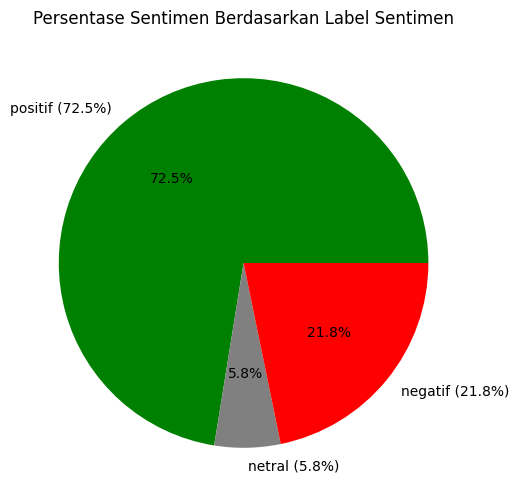

In [9]:
rating_summary = {
    "positif": len(clean_df[clean_df["sentimen"] == "positif"]),
    "netral": len(clean_df[clean_df["sentimen"] == "netral"]),
    "negatif": len(clean_df[clean_df["sentimen"] == "negatif"])
}

print("Jumlah data berdasarkan label sentimen: ",rating_summary)

total_reviews = sum(rating_summary.values())

rating_percentage = {key: (value / total_reviews) * 100 for key, value in rating_summary.items()}

plt.figure(figsize=(6, 6))
plt.pie(rating_summary.values(), labels=[f"{label} ({rating_percentage[label]:.1f}%)" for label in rating_summary.keys()],
        autopct='%1.1f%%', colors=['green', 'gray', 'red'])
plt.title("Persentase Sentimen Berdasarkan Label Sentimen")
plt.show()


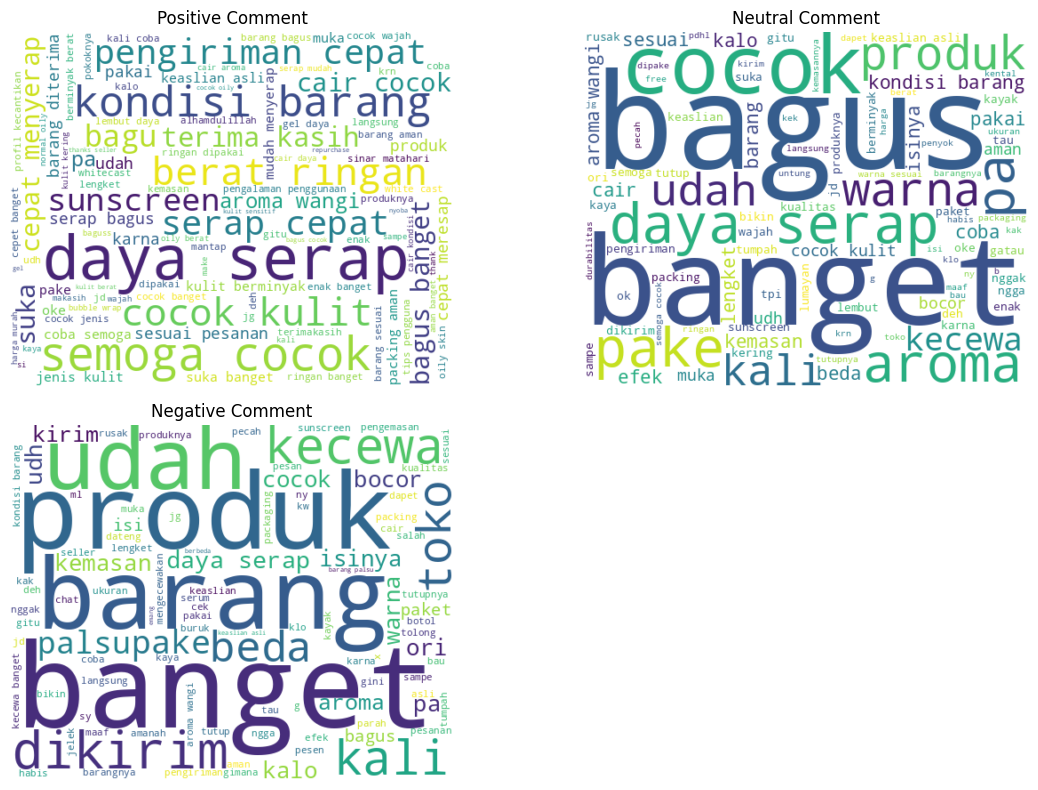

In [10]:
df = pd.DataFrame(clean_df)

positif_text = " ".join(df[df["sentimen"] == "positif"]["final_comment"])
netral_text = " ".join(df[df["sentimen"] == "netral"]["final_comment"])
negatif_text = " ".join(df[df["sentimen"] == "negatif"]["final_comment"])

def generate_wordcloud(text, title, ax):
    wordcloud = WordCloud(width=500, height=400, background_color="white",
                          colormap="viridis", max_words=100).generate(text)
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.set_title(title, fontsize=12)
    ax.axis("off")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

generate_wordcloud(positif_text, "Positive Comment", axes[0, 0])
generate_wordcloud(negatif_text, "Negative Comment", axes[1, 0])
generate_wordcloud(netral_text, "Neutral Comment", axes[0, 1])

fig.delaxes(axes[1, 1])

plt.tight_layout()
plt.show()


In [11]:
X = clean_df['final_comment']
y = clean_df['sentimen']

In [12]:
svm_tfidf = TfidfVectorizer(ngram_range=(1,3),max_features=30000, min_df=10, max_df=0.85)
svm_X_tfidf = svm_tfidf.fit_transform(X)
svm_features_df = pd.DataFrame(svm_X_tfidf.toarray(), columns=svm_tfidf.get_feature_names_out())

svm_X_train, svm_X_test, svm_y_train, svm_y_test = train_test_split(svm_X_tfidf, y, test_size=0.2, random_state=42)

svm_model = SVC(kernel='linear',random_state=42)
svm_model.fit(svm_X_train, svm_y_train)

svm_y_pred_train = svm_model.predict(svm_X_train)
svm_y_pred_test = svm_model.predict(svm_X_test)

svm_accuracy_train = accuracy_score(svm_y_train, svm_y_pred_train)
svm_accuracy_test = accuracy_score(svm_y_test, svm_y_pred_test)

print('SVM TF-IDF - Training Accuracy:', svm_accuracy_train)
print('SVM TF-IDF - Testing Accuracy:', svm_accuracy_test)

SVM TF-IDF - Training Accuracy: 0.9240176703092304
SVM TF-IDF - Testing Accuracy: 0.8997582294960015


In [13]:
rf_tfidf = TfidfVectorizer(ngram_range=(1,3),max_features=30000, min_df=10, max_df=0.85)
rf_X_tfidf = rf_tfidf.fit_transform(X)
rf_features_df = pd.DataFrame(rf_X_tfidf.toarray(), columns=rf_tfidf.get_feature_names_out())

rf_X_train, rf_X_test, rf_y_train, rf_y_test = train_test_split(rf_X_tfidf, y, test_size=0.3, random_state=42)

rf_model = RandomForestClassifier(n_estimators=250,max_depth=50, random_state=42)
rf_model.fit(rf_X_train, rf_y_train)

rf_y_pred_train = rf_model.predict(rf_X_train)
rf_y_pred_test = rf_model.predict(rf_X_test)

rf_accuracy_train = accuracy_score(rf_y_train, rf_y_pred_train)
rf_accuracy_test = accuracy_score(rf_y_test, rf_y_pred_test)

print('Random Forest TF-IDF - Training Accuracy:', rf_accuracy_train)
print('Random Forest TF-IDF - Testing Accuracy:', rf_accuracy_test)

Random Forest TF-IDF - Training Accuracy: 0.9319764043152469
Random Forest TF-IDF - Testing Accuracy: 0.8755114693118413


In [14]:
tokenized_data = [sentence.split() for sentence in X]

word2vec_model = Word2Vec(sentences=tokenized_data, vector_size=200, window=7, min_count=10, workers=4)

def get_word2vec_vector(comment, word2vec_model):
    words = comment.split()
    word_vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    if len(word_vectors) == 0:
        return np.zeros(word2vec_model.vector_size)
    return np.mean(word_vectors, axis=0)

X_word2vec = np.array([get_word2vec_vector(comment, word2vec_model) for comment in X])

word2vec_X_train, word2vec_X_test, word2vec_y_train, word2vec_y_test = train_test_split(X_word2vec, y, test_size=0.2, random_state=42)

rf_model_word2vec = RandomForestClassifier(n_estimators=150,max_depth=10, random_state=42)
rf_model_word2vec.fit(word2vec_X_train, word2vec_y_train)

y_pred_train_rf = rf_model_word2vec.predict(word2vec_X_train)
y_pred_test_rf = rf_model_word2vec.predict(word2vec_X_test)

accuracy_train_rf = accuracy_score(word2vec_y_train, y_pred_train_rf)
accuracy_test_rf = accuracy_score(word2vec_y_test, y_pred_test_rf)

print('Random Forest Word2Vec - accuracy_train:', accuracy_train_rf)
print('Random Forest Word2Vec - accuracy_test:', accuracy_test_rf)

Random Forest Word2Vec - accuracy_train: 0.9172285514996512
Random Forest Word2Vec - accuracy_test: 0.8841361353914823


In [15]:
def predict_sentiment(text, model, vectorizer=None, word2vec_model=None):
    if vectorizer:
        text_vector = vectorizer.transform([text])
        if text_vector.shape[1] == 0:
            return "kata tidak dikenali"
        prediction = model.predict(text_vector)
    elif word2vec_model:
        text_vector = get_word2vec_vector(text, word2vec_model)
        if text_vector is None:
            return "kata tidak dikenali"
        prediction = model.predict([text_vector])

    return prediction[0]


In [16]:
input_texts = [
    "Pengiriman lama dan barang rusak",
    "Produk bagus di kulit",
    "Kualitas sangat buruk dan mengecewakan",
    "Pelayanan sangat baik dan cepat",
    "Barang tidak sesuai dengan deskripsi",
    "Harga sangat terjangkau untuk kualitas seperti ini",
    "Saya kecewa dengan pelayanan yang diberikan",
    "Sangat puas dengan produk ini, sesuai ekspektasi",
    "Tidak ada yang spesial, produk biasa saja",
    "Produk ini palsu dan pengirimannya lama",
    "Produk belum di coba"
]


results = []

for text in input_texts:
    svm_tf = predict_sentiment(text, svm_model, vectorizer=svm_tfidf)
    rf_tf = predict_sentiment(text, rf_model, vectorizer=rf_tfidf)
    rf_word2 = predict_sentiment(text, rf_model_word2vec, word2vec_model=word2vec_model)

    results.append([text, svm_tf, rf_tf, rf_word2])

headers = ["Teks", "SVM (TF-IDF)", "RF (TF-IDF)", "RF (Word2Vec)"]
print(tabulate(results, headers=headers, tablefmt="grid"))


+----------------------------------------------------+----------------+---------------+-----------------+
| Teks                                               | SVM (TF-IDF)   | RF (TF-IDF)   | RF (Word2Vec)   |
+====================================================+================+===============+=================+
| Pengiriman lama dan barang rusak                   | negatif        | negatif       | negatif         |
+----------------------------------------------------+----------------+---------------+-----------------+
| Produk bagus di kulit                              | positif        | positif       | positif         |
+----------------------------------------------------+----------------+---------------+-----------------+
| Kualitas sangat buruk dan mengecewakan             | negatif        | negatif       | negatif         |
+----------------------------------------------------+----------------+---------------+-----------------+
| Pelayanan sangat baik dan cepat             